In [2]:
%matplotlib inline

import numpy as np
import pandas as pd 
from skimage import io, color
import matplotlib.pyplot as plt
import cv2
import numpy as np

import os
PATH = "./data/"

**UTILS**

In [5]:
def display(img):
    plt.figure()
    plt.set_cmap('gray')
    plt.imshow(img)
    plt.show()


def combineLAB(l, a, b):
    shape = (l.shape[0], l.shape[1], 3)
    zeros = np.zeros(shape)
    zeros[:, :, 0] = l
    zeros[:, :, 1] = a
    zeros[:, :, 2] = b
    return zeros


def combineAB(a, b):
    shape = (a.shape[0], b.shape[1], 2)
    zeros = np.zeros(shape)
    zeros[:, :, 0] = a
    zeros[:, :, 1] = b
    return zeros


def combineL_AB(l, ab):
    shape = (l.shape[0], l.shape[1], 3)
    zeros = np.zeros(shape)
    zeros[:, :, 0] = l
    zeros[:, :, 1] = ab[:, :, 0]
    zeros[:, :, 2] = ab[:, :, 1]
    return zeros


def make3channels(gray):
    shape = (gray.shape[0], gray.shape[1], 3)
    zeros = np.zeros(shape)
    zeros[:, :, 0] = gray
    zeros[:, :, 1] = gray
    zeros[:, :, 2] = gray
    return zeros


def get_l_from_gray(img_path):
    img = io.imread(img_path)
    gray = color.rgb2gray(img)
    gray = make3channels(gray)
    lgray = color.rgb2lab(gray, illuminant='D50')[:, :, 0]
    return lgray


def get_ab_from_file(file):
    img = io.imread(file)
    ab = np.zeros((64, 64, 2))
    ab[:, :, 0] = img[:, :, 1]
    ab[:, :, 1] = img[:, :, 2]
    return ab


def lab_normal_image(path):
    l, ab = load_img_for_training(path)
    l, ab = (l-127.5)/127.5, (ab-127.5)/127.5
    return l, ab


def rgb_image(l, ab):
    l, ab = l*127.5 + 127.5, (ab*127.5)+127.5
    lab = combineL_AB(l, ab)
    rgb = color.lab2rgb(lab, illuminant='D50')
    return rgb


def load_img_for_training(img_path):
    img = io.imread(img_path)
    lab = color.rgb2lab(img, illuminant='D50')
    l, a, b = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]
    ab = combineAB(a, b)
    lgray = get_l_from_gray(img_path)
    return lgray, ab


def save_ab_file(image, filepath):
    # add in 0zeros to its first component
    shape = (image.shape[0], image.shape[1], 3)
    new_ab_image = np.zeros(shape)
    new_ab_image[:, :, 1] = image[:, :, 0]
    new_ab_image[:, :, 2] = image[:, :, 1]
    save_file(new_ab_image, filepath)


def save_file(image, filepath):
    io.imsave(filepath, image)


def load_ab_image(path):
    img = io.imread(path)
    shape = (img.shape[0], img.shape[1], 2)
    ab = np.zeros(shape)
    ab[:, :, 0] = img[:, :, 1]
    ab[:, :, 1] = img[:, :, 2]
    return ab


**Data Loading**

In [3]:
end = 3000
def get_data(path):
    start = 1

    x_data = np.zeros((end, 64, 64))
    y_data = np.zeros((end, 64, 64, 2))

    for i in range(start, end+1):
        filename = path + str(i) + ".png"
        l, ab = lab_normal_image(filename)
        x_data[i-1] = l
        y_data[i-1] = ab

    return x_data, y_data

x_data,y_data = get_data(PATH)
print("X SHAPE:",x_data.shape)
print("Y SHAPE:",y_data.shape)


X SHAPE: (3000, 64, 64)
Y SHAPE: (3000, 64, 64, 2)


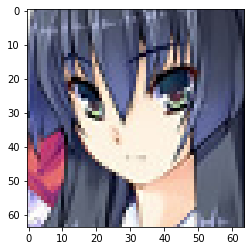

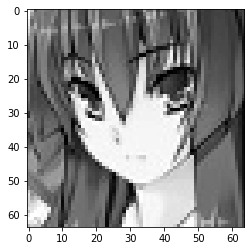

In [4]:
l_sample,ab_sample = x_data[3],y_data[3]
rgb_sample = rgb_image(l_sample,ab_sample)
display(rgb_sample)
display(l_sample)

**GAN Architecture**

In [13]:
from keras import *
from keras.layers import *
from keras.activations import *
from keras.optimizers import *
from matplotlib import pyplot as plt
#from utils import *
from keras.initializers import RandomNormal, Zeros

In [59]:
def residual_block(feature, dropout=False):
    x = Conv2D(256, kernel_size=3, strides=1, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(feature)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout:
        x = Dropout(0.5)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return Add()([feature, x])


def conv_block(feature, out_channel, downsample=True, dropout=False):
    if downsample:
        x = Conv2D(out_channel, kernel_size=4, strides=2, padding='same', kernel_initializer=RandomNormal(
            mean=0.0, stddev=0.02), bias_initializer=Zeros())(feature)
    else:
        x = Conv2DTranspose(out_channel, kernel_size=4, strides=2, padding='same', kernel_initializer=RandomNormal(
            mean=0.0, stddev=0.02), bias_initializer=Zeros())(feature)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout:
        x = Dropout(0.5)(x)
    return x


def build_model(n_block=5):
    image_size = 64
    input_channel = 1
    output_channel = 2
    input = Input(shape=(image_size, image_size, input_channel))
    x = Conv2D(64, kernel_size=7, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(input)  # use reflection padding instead
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # downsample
    x = Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # downsample
    x = Conv2D(256, kernel_size=3, strides=2, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    for i in range(n_block):
        x = residual_block(x)
    # upsample
    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same',
                        kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # upsample
    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # out
    x = Conv2D(output_channel, kernel_size=7, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)  # use reflection padding instead
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    model = Model(inputs=input, outputs=x)
    model.summary()
    return model

def save_images(generator, samples):
    ab_values = generator.predict(samples)
    plt.figure()
    plt.set_cmap('gray')
    for i in range(ab_values.shape[0]):
        l_val = samples[i][:,:,0]
        ab_val = ab_values[i]
        rgb = rgb_image(l_val, ab_val)
        if i == 0:
            display(rgb)
        ax = plt.subplot(4, 4, i+1)
        im = ax.imshow(rgb)
        plt.tight_layout()
        plt.title(i)
    plt.show()
    plt.savefig('gan_generated_image.png')


    
def train_network(x_data,y_data,epochs=100, batch_size=128, save_interval=5):
    input_shape = (64, 64, 1)
    output_shape = (64, 64, 2)
    model = build_model()
    model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
    model.fit(x_data,y_data,validation_split=0.1,epochs=epochs,batch_size=128,)
    model.save('model.h5')
    print("MODEL SAVED")
    return model
    


In [60]:
import visualkeras
from PIL import ImageFont
model = build_model()
font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model , legend=True, font=font,draw_shapes=2,padding_vertical=75,padding_left=150,draw_reversed=True).show()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_318 (Conv2D)            (None, 64, 64, 64)   3200        ['input_29[0][0]']               
                                                                                                  
 batch_normalization_356 (Batch  (None, 64, 64, 64)  256         ['conv2d_318[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_356 (Activation)    (None, 64, 64, 64)   0           ['batch_normalization_356[

In [159]:
x_data = x_data.reshape((end,64,64,1))
model=train_network(x_data,y_data,epochs=10)

Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_162 (Conv2D)            (None, 64, 64, 64)   3200        ['input_15[0][0]']               
                                                                                                  
 batch_normalization_182 (Batch  (None, 64, 64, 64)  256         ['conv2d_162[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_182 (Activation)    (None, 64, 64, 64)   0           ['batch_normalization_182[

C:\Users\SHIBASAN\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:338: UserWarning: Color data out of range: Z < 0 in 143 pixels
  return func(*args, **kwargs)


<Figure size 432x288 with 0 Axes>

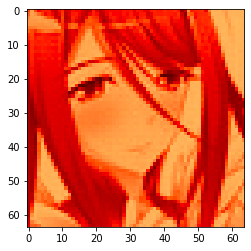

C:\Users\SHIBASAN\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:338: UserWarning: Color data out of range: Z < 0 in 262 pixels
  return func(*args, **kwargs)
C:\Users\SHIBASAN\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:338: UserWarning: Color data out of range: Z < 0 in 765 pixels
  return func(*args, **kwargs)
C:\Users\SHIBASAN\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:338: UserWarning: Color data out of range: Z < 0 in 3189 pixels
  return func(*args, **kwargs)
C:\Users\SHIBASAN\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:338: UserWarning: Color data out of range: Z < 0 in 2767 pixels
  return func(*args, **kwargs)
C:\Users\SHIBASAN\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\_shared\utils.py:338: UserWarning: Color data out of range: Z < 0 in 2509 pixels
  return func(*args, **kwargs)
C:\Users\SHIBASAN\AppData\L

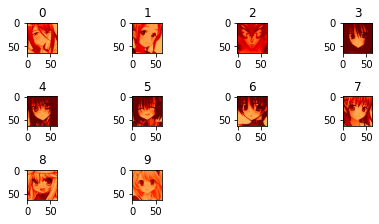

<Figure size 432x288 with 0 Axes>

In [150]:
samples = x_data[50:60]
save_images(model,samples)

In [151]:
layer_outputs = [layer.output for layer in model.layers]
layer_outputs


[<KerasTensor: shape=(None, 64, 64, 1) dtype=float32 (created by layer 'input_14')>,
 <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'conv2d_148')>,
 <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'batch_normalization_166')>,
 <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'activation_166')>,
 <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'conv2d_149')>,
 <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'batch_normalization_167')>,
 <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'activation_167')>,
 <KerasTensor: shape=(None, 16, 16, 256) dtype=float32 (created by layer 'conv2d_150')>,
 <KerasTensor: shape=(None, 16, 16, 256) dtype=float32 (created by layer 'batch_normalization_168')>,
 <KerasTensor: shape=(None, 16, 16, 256) dtype=float32 (created by layer 'activation_168')>,
 <KerasTensor: shape=(None, 16, 16, 256) dtype=float32 (created by

In [152]:
# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

1 conv2d_148 (None, 64, 64, 64)
4 conv2d_149 (None, 32, 32, 128)
7 conv2d_150 (None, 16, 16, 256)
10 conv2d_151 (None, 16, 16, 256)
13 conv2d_152 (None, 16, 16, 256)
17 conv2d_153 (None, 16, 16, 256)
20 conv2d_154 (None, 16, 16, 256)
24 conv2d_155 (None, 16, 16, 256)
27 conv2d_156 (None, 16, 16, 256)
31 conv2d_157 (None, 16, 16, 256)
34 conv2d_158 (None, 16, 16, 256)
38 conv2d_159 (None, 16, 16, 256)
41 conv2d_160 (None, 16, 16, 256)
45 conv2d_transpose_18 (None, 32, 32, 128)
48 conv2d_transpose_19 (None, 64, 64, 64)
51 conv2d_161 (None, 64, 64, 2)


(64, 64, 1, 64)


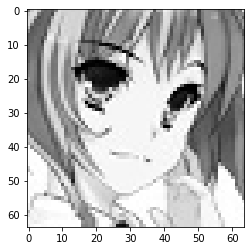

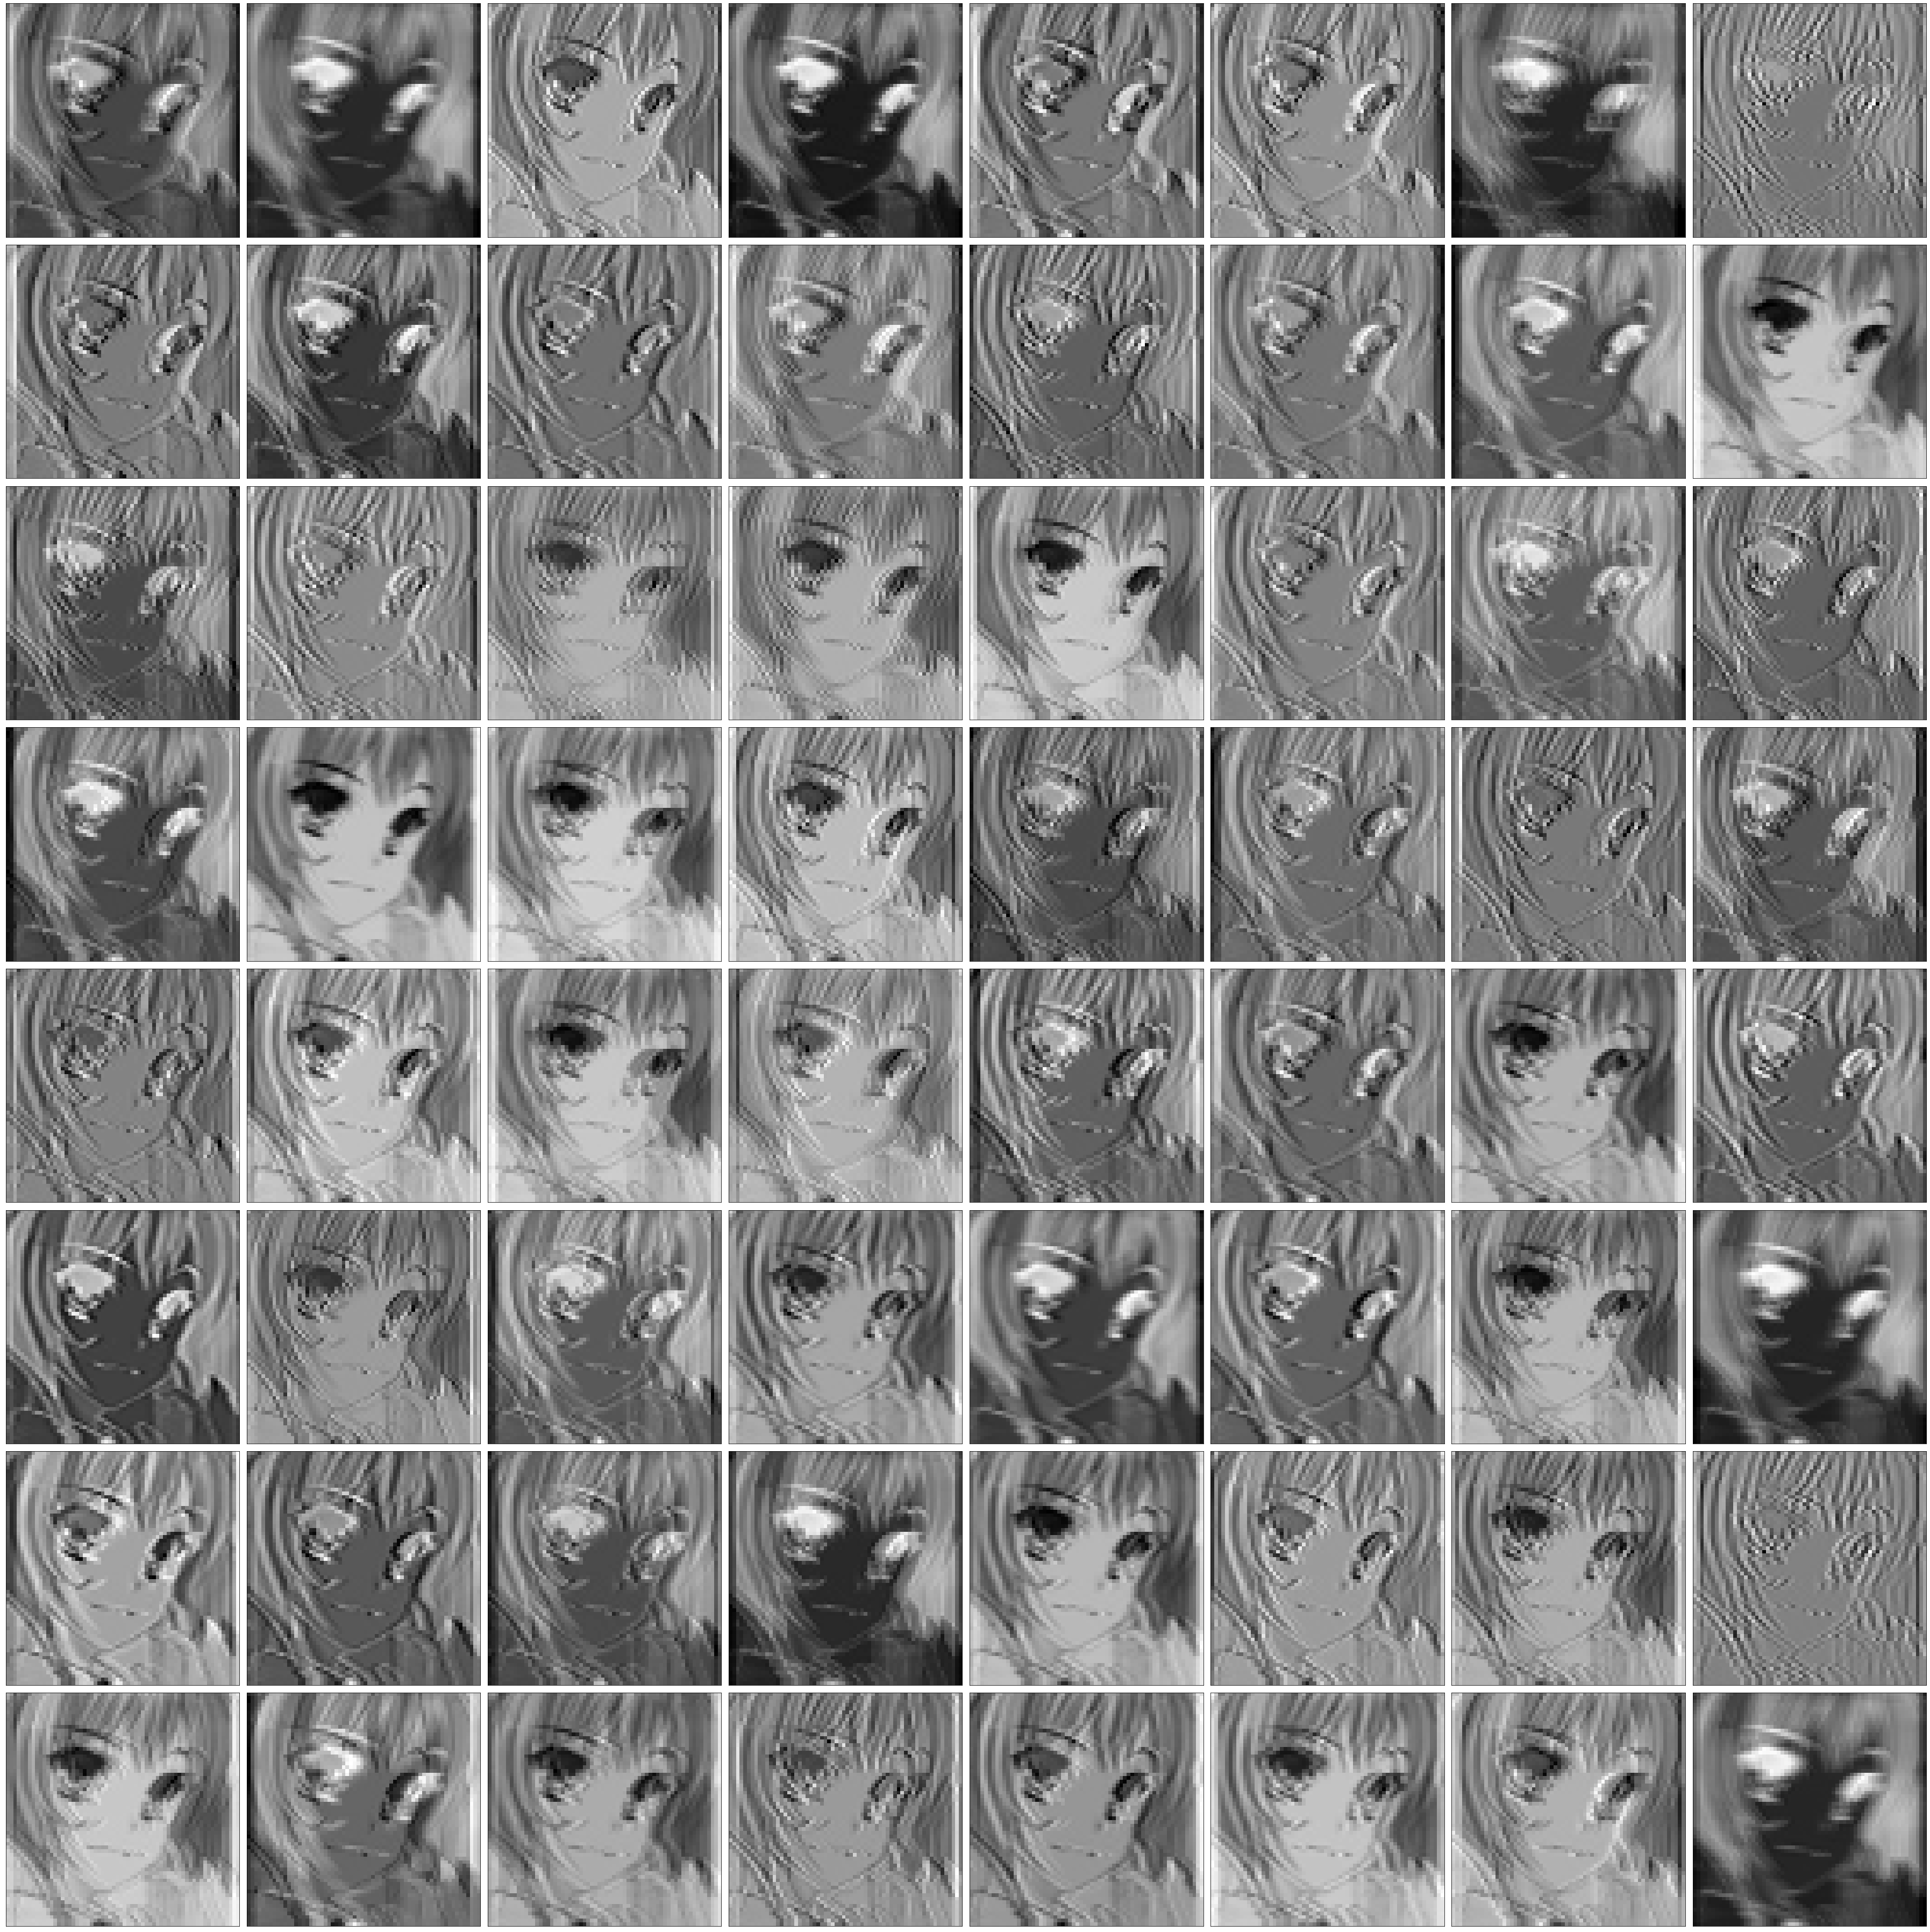

In [239]:
f_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
img = x_data[4]
plt.imshow(img[:,:,0])
feature_maps = f_model.predict(img)
print(feature_maps.shape)
# display the feature maps
def display_feature_maps():
	fig, axs = plt.subplots(8, 8, figsize=(50,50))
	for i, ax in enumerate(axs.flat):
		# plot feature map
		ax.imshow(feature_maps[:, :, :,i], cmap='binary')
		# remove any labels from the axes
		ax.set_xticks([])
		ax.set_yticks([])
	plt.tight_layout()
	plt.show()
display_feature_maps()


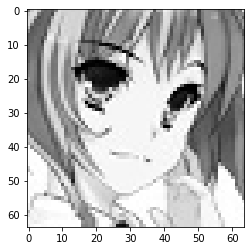

(64, 64, 4, 2)


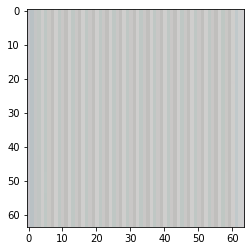

In [269]:
f_model = Model(inputs=model.inputs, outputs=model.layers[51].output)
img = x_data[4]
plt.imshow(img[:,:,0])
plt.show()
feature_maps = f_model.predict(img)
print(feature_maps.shape)
# display the feature maps
def display_feature_maps():
	fig, axs = plt.subplots(8, 8, figsize=(50,50))
	for i, ax in enumerate(axs.flat):
		# plot feature map
		ax.imshow(feature_maps[:, :,1,i], cmap='binary')
		# remove any labels from the axes
		ax.set_xticks([])
		ax.set_yticks([])
	plt.tight_layout()
	plt.show()
#display_feature_maps()
plt.imshow(feature_maps[ :,:,:,1])
plt.show()